In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2412_Capstone AI\Capstone data\Data'
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel

In [3]:
df = process_folder(path_to_data, path_to_output, plot=False, labels=True)
feature_scaler, target_scaler, X_train, y_train, X_val, y_val, X_test, y_test = save_second_scaler(df)

Binlog data extracted
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 60, 'bin_file': '2024-11-12T145426.bin'}
1482760632 datapoints extracted
LABELS: 916 bubble labels with VeloOut != -1 extracted.
Saved bubbles to H:\My Documents\Capstone results\60_2024-11-12T145426_bubbles.csv
No missing labels.
EXTRACTED: 916 bubbles have VeloOut != -1 out of 3437 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-12T145426    E0    -1 -1.000000   
1  1_2024-11-12T145426    E1    -1 -1.000000   
2  2_2024-11-12T145426    E2    -1 -1.000000   
3  3_2024-11-12T145426    E3    -1 -1.000000   
4  4_2024-11-12T145426    E4    L0  0.683939   

                                          VoltageOut  FlowRate     Frequency  
0  [0.7072969675064087, 0.6999114751815796, 0.673...        60  2.083333e+07  
1  [0.7262794971466064, 0.7157200574874878, 0.697...        60  2.083333e+07  
2  [0.730491042137146, 0.7262794971

In [4]:
chance = 0.3
bins = 20
X_train, y_train = random_noise(X_train, y_train, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train, bins)
factors = calculate_duplication_factors(hist)
X_train, y_train = duplicate_and_augment_data(X_train, y_train, bin_indices, factors, noise=0.005)
X_train, y_train = flatten_data_distribution(X_train, y_train, bins, scaling_factor=0.5, noise=0.005)

Epoch 1/100 - Train Loss: 3.6079 - Val Loss: 1.3919
Epoch 2/100 - Train Loss: 3.1940 - Val Loss: 1.5309
Epoch 3/100 - Train Loss: 2.8567 - Val Loss: 1.7913
Epoch 4/100 - Train Loss: 2.5841 - Val Loss: 2.2295
Epoch 5/100 - Train Loss: 2.4028 - Val Loss: 2.8782
Epoch 6/100 - Train Loss: 2.3751 - Val Loss: 3.4420
Epoch 7/100 - Train Loss: 2.4627 - Val Loss: 3.5474
Epoch 8/100 - Train Loss: 2.4793 - Val Loss: 3.3244
Epoch 9/100 - Train Loss: 2.4143 - Val Loss: 2.9761
Epoch 10/100 - Train Loss: 2.3362 - Val Loss: 2.6404
Epoch 11/100 - Train Loss: 2.2897 - Val Loss: 2.3801
Epoch 12/100 - Train Loss: 2.2794 - Val Loss: 2.2065
Epoch 13/100 - Train Loss: 2.2874 - Val Loss: 2.1082
Epoch 14/100 - Train Loss: 2.2943 - Val Loss: 2.0691
Epoch 15/100 - Train Loss: 2.2902 - Val Loss: 2.0761
Epoch 16/100 - Train Loss: 2.2743 - Val Loss: 2.1199
Epoch 17/100 - Train Loss: 2.2511 - Val Loss: 2.1923
Epoch 18/100 - Train Loss: 2.2265 - Val Loss: 2.2839
Epoch 19/100 - Train Loss: 2.2058 - Val Loss: 2.3819
Ep

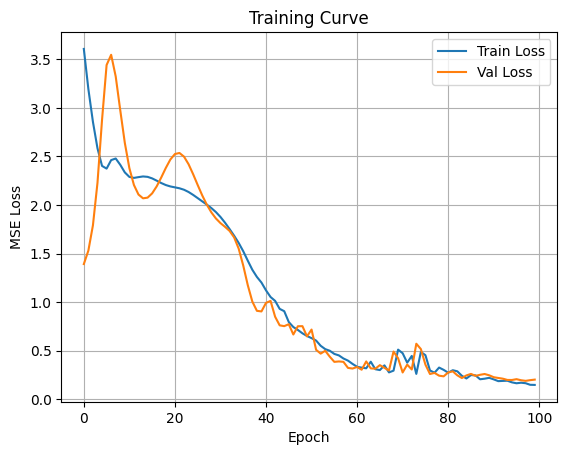

In [8]:
X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Model config from your best setup
model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
model.to('cpu')

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1500
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred_train = model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Plot loss curve
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Predict on validation set
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.019 cm/s
MAE: 0.066 cm/s
R² Score: 0.851


In [10]:
print("Prediction range:", y_pred.min(), y_pred.max())


Prediction range: 0.04761108 1.5013148


In [ ]:
gru2_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru2_model.to('cpu')

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.02)
criterion = torch.nn.MSELoss()

# Training
epochs = 700
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
lstm_model = LSTMModel(input_size=1, hidden_size=30, num_layers=2)
lstm_model.to('cpu')

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.008)

# Training loop
epochs = 1500
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()